In [60]:
import pandas as pd
import numpy as np



In [61]:
df = pd.read_csv(r'merged_data.txt')
df.head()

df = df.iloc[:,:-1]
df.dtypes

0    float64
1    float64
2    float64
3    float64
dtype: object

In [62]:

from sklearn.preprocessing import MinMaxScaler
feature_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = feature_scaler.fit_transform(df)
df_scaled = pd.DataFrame(data=df_scaled)
df_scaled.head()

,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.083333,0.458333,0.084746,0.041667
3,0.194444,0.666667,0.067797,0.041667
4,0.083333,0.583333,0.067797,0.083333


In [63]:
som_width = 8
som_length = 8
epochs = 10000
initial_learning_rate=0.01
np.random.seed(10)

In [64]:
raws,cols = df_scaled.shape
print("Data set raw count=%d column count=%d" %(raws, cols))

Data set raw count=216 column count=4


In [65]:
initial_radius = max(som_width, som_length)/2
time_constant =  epochs/np.log(initial_radius)

In [66]:
som_net = np.random.random((som_width, som_length, cols))
print("Initial weights set to SOM network:")
print(som_net)

Initial weights set to SOM network:
[[[0.77132064 0.02075195 0.63364823 0.74880388]
  [0.49850701 0.22479665 0.19806286 0.76053071]
  [0.16911084 0.08833981 0.68535982 0.95339335]
  [0.00394827 0.51219226 0.81262096 0.61252607]
  [0.72175532 0.29187607 0.91777412 0.71457578]
  [0.54254437 0.14217005 0.37334076 0.67413362]
  [0.44183317 0.43401399 0.61776698 0.51313824]
  [0.65039718 0.60103895 0.8052232  0.52164715]]

 [[0.90864888 0.31923609 0.09045935 0.30070006]
  [0.11398436 0.82868133 0.04689632 0.62628715]
  [0.54758616 0.819287   0.19894754 0.8568503 ]
  [0.35165264 0.75464769 0.29596171 0.88393648]
  [0.32551164 0.1650159  0.39252924 0.09346037]
  [0.82110566 0.15115202 0.38411445 0.94426071]
  [0.98762547 0.45630455 0.82612284 0.25137413]
  [0.59737165 0.90283176 0.53455795 0.59020136]]

 [[0.03928177 0.35718176 0.07961309 0.30545992]
  [0.33071931 0.7738303  0.03995921 0.42949218]
  [0.31492687 0.63649114 0.34634715 0.04309736]
  [0.87991517 0.76324059 0.87809664 0.41750914]


In [67]:
def update_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def update_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_euclidian_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

In [68]:
def find_best_matching_Unit(data_point):
    bmu_pos = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    input_dim = len(data_point)
    
    for x in range(som_width):
        for y in range(som_length):
            som_weight_vector = som_net[x, y, :].reshape(1, 4)
            euclidian_dist = calculate_euclidian_dis(som_weight_vector, data_point)
            if euclidian_dist < min_dist:
                min_dist = euclidian_dist
                bmu_pos = np.array([x, y])
    
    bmu = som_net[bmu_pos[0], bmu_pos[1], :].reshape(1, 4)
    return (bmu, bmu_pos)

In [69]:
def neighbourhood_function(bmu_location, selected_node_location, radius):
    euclidien_dist_to_bmu = calculate_euclidian_dis(bmu_location, selected_node_location)
    return np.exp(-euclidien_dist_to_bmu / (2* (radius**2)))

In [70]:
#shuffle data set
df_scaled = df_scaled.sample(frac=1)

rad_values = list()
learn_rates_values = list()
rad_values.append(initial_radius)
learn_rates_values.append(initial_learning_rate)

for i in range(epochs):
    data_point = np.array(df_scaled.sample())
    bmu, bmu_idx = find_best_matching_Unit(data_point)

    r_new = update_radius(initial_radius, i, time_constant)
    new_learning_rate = update_learning_rate(initial_learning_rate, i, epochs)
    
    rad_values.append(r_new)
    learn_rates_values.append(new_learning_rate)
    
    for x in range(som_width):
        for y in range(som_length):
            w = som_net[x, y, :].reshape(1, 4)
            w_dist = calculate_euclidian_dis(np.array([x, y]), bmu_idx)
            
            if w_dist <= r_new:
                influence = neighbourhood_function(bmu, w, r_new)
                new_w = w + (new_learning_rate * influence * (data_point - w))
                som_net[x, y, :] = new_w.reshape(1, 4)

Text(0.5, 1.0, 'Radius values')

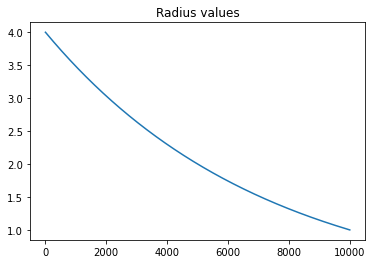

In [71]:
from matplotlib import pyplot as plt
plt.plot(rad_values)
plt.title('Radius values')

Text(0.5, 1.0, 'Learning Rates values')

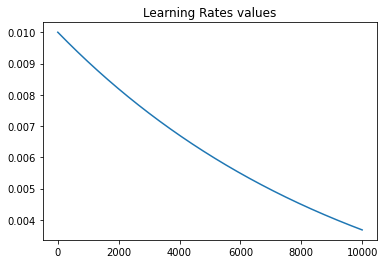

In [72]:
plt.plot(learn_rates_values)
plt.title('Learning Rates values')

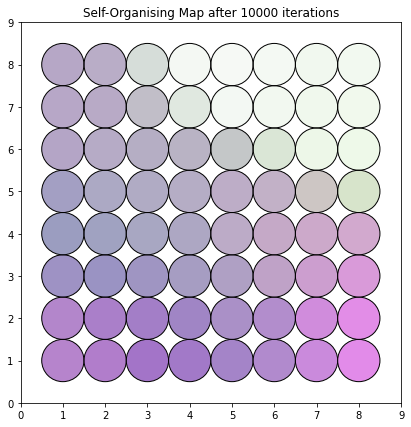

In [73]:
from matplotlib import patches as patches

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, aspect='equal')
ax.set_xlim((0, som_width+1))
ax.set_ylim((0, som_length+1))
ax.set_title('Self-Organising Map after %d iterations' % epochs)

for x in range(1, som_width + 1):
    for y in range(1, som_length + 1):
        ax.add_patch(patches.Circle((x, y), 0.5, facecolor=som_net[x-1,y-1,:], edgecolor='black'))
plt.show()

fig.savefig('SOM_iris_data.png')

In [74]:
u_matrix = np.zeros((som_width-1, som_length-1))

for x in range(1, som_width):
    for y in range(1, som_length):
        neighbour_list = list()
        print("-"* 100)
        print("neighbour cordinates of x=%d, y=%d" %(x,y))
        for u in range(x-1, x+2):
            if (u < 0 or u > (som_width-1)):
                continue
            for v in range(y-1, y+2):
                if(v < 0 or v > (som_length-1)):
                    continue
                if (u == x and v == y):
                    continue
                neighbour_list.append(np.array([u,v]))
                print(u,v)
        sum=0
        for idx in neighbour_list:
            sum += calculate_euclidian_dis(som_net[x,y,:], som_net[idx[0],idx[1],:])
        
        avg = sum/len(neighbour_list)
        print("Sum of distance to neighbour weights=%f, average=%f" % (sum, avg))     
        u_matrix[x-1,y-1] = avg

----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=1
0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2
Sum of distance to neighbour weights=0.964071, average=0.120509
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=2
0 1
0 2
0 3
1 1
1 3
2 1
2 2
2 3
Sum of distance to neighbour weights=1.037761, average=0.129720
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=3
0 2
0 3
0 4
1 2
1 4
2 2
2 3
2 4
Sum of distance to neighbour weights=0.711704, average=0.088963
----------------------------------------------------------------------------------------------------
neighbour cordinates of x=1, y=4
0 3
0 4
0 5
1 3
1 5
2 3
2 4
2 5
Sum of distance to neighbour weights=0.626678, average=0.078335
--------------------------------------------------------------------------------

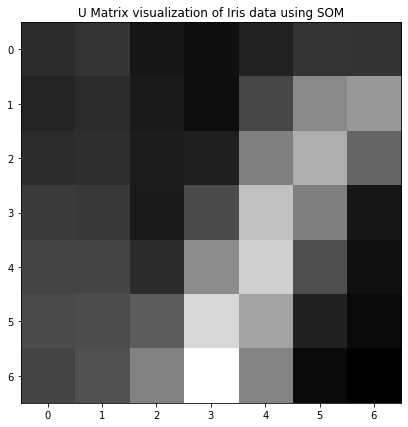

In [75]:
fig = plt.figure(figsize=(7,7))
plt.title("U Matrix visualization of Iris data using SOM")
plt.imshow(u_matrix, cmap="gray")
plt.show()
fig.savefig('U_Matrix_iris.png')